## Financial Planning Demonstration

This notebook is meant to demonstrate how the financial planning library can be used to project incomes, expenses, cash flow, asset growth and liabilities into the future.

Caveat: Currently there is no consideration for inflation in this model.

In [ ]:
# Imports.

from datetime import date as Date

from financial_planning import financial as fin
from financial_planning import graph

# Only for development
import importlib
importlib.reload(fin)
importlib.reload(graph)



<module 'financial_planning.graph' from '/Users/siggi/Documents/Development/financial-planning/financial_planning/graph.py'>

## Dates

In [ ]:
# Dates

start_date = Date.fromisoformat("2020-01-01")
intermediate_date = Date.fromisoformat("2021-01-01")
end_date = Date.fromisoformat("2025-01-01")

dates = fin.monthly_date_range(
    start_date=start_date,
    end_date=end_date,
)


## Incomes

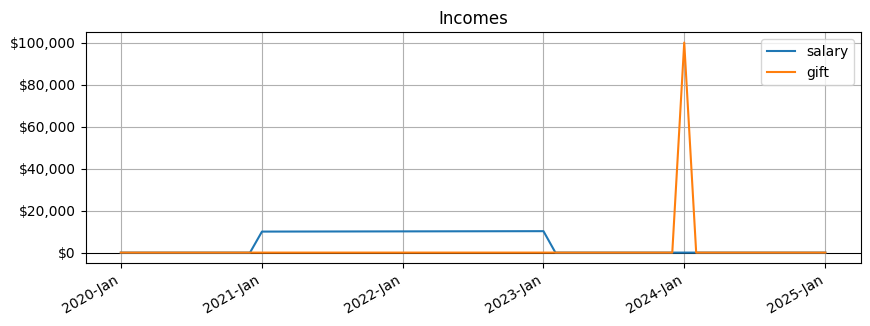

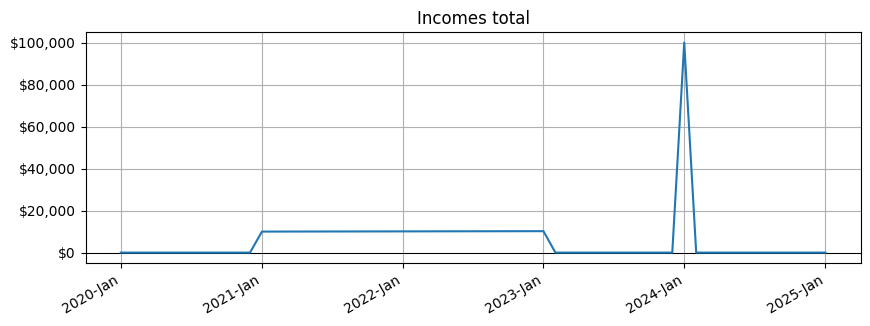

In [ ]:

incomes = {
    'salary': fin.DateRangeSource(
        initial_monthly=10000,
        growth=fin.AnnualFixedRate(0.01),
        start_date=intermediate_date,
        end_date=Date.fromisoformat("2023-01-01"),
    ),
    'gift': fin.OneTimeSource(
        amount=10_000,
        date=Date.fromisoformat("2024-01-01"),
    ),
}

# Create a graph.
output = fin.process(dates, incomes=incomes)
graph.plot('Incomes', dates, output.incomes)
if len(output.incomes) > 1:
    graph.plot('Incomes total', dates, output.incomes_total)

## Liabilities

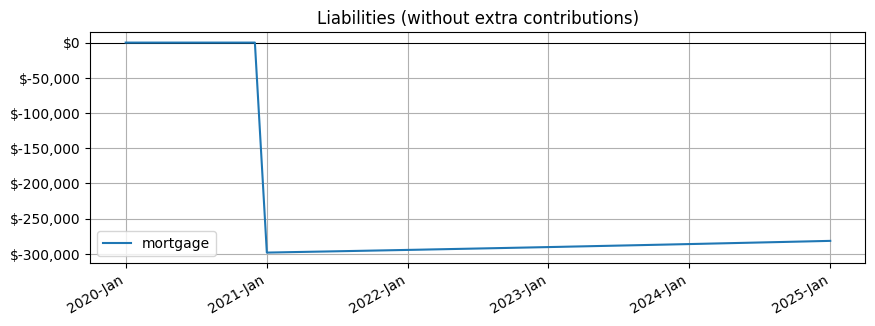

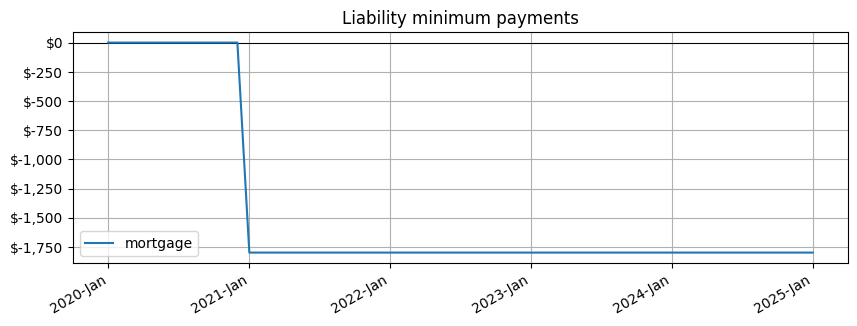

In [ ]:
liabilities = {
    "mortgage": fin.Liability(
        -300_000,
        start_date=intermediate_date,
        rate=fin.AnnualFixedRate(0.06),
        duration_months=30 * 12,
    )
}

# Create a graph.
output = fin.process(dates, liabilities=liabilities)
graph.plot('Liabilities (without extra contributions)', dates, output.liabilities)
graph.plot('Liability minimum payments', dates, output.expenses)

## Expenses

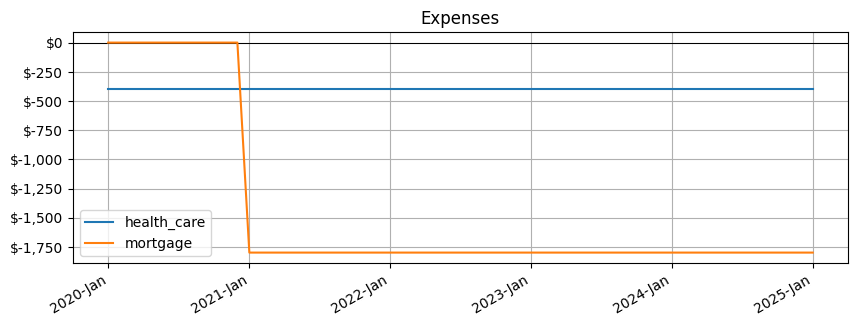

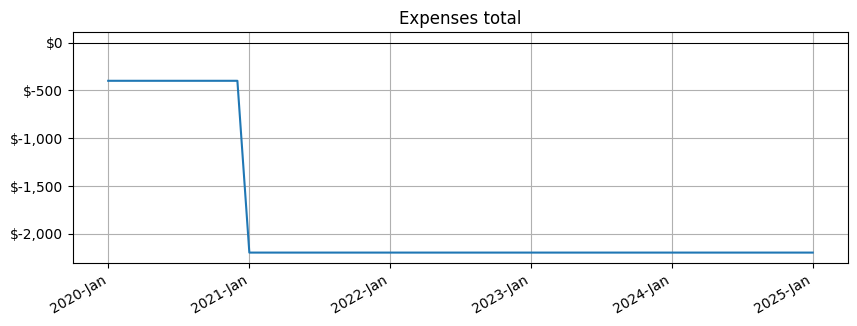

In [ ]:
expenses = {
    'health_care': fin.DateRangeSource(
        initial_monthly=-400,
        growth=fin.AnnualFixedRate(0.0),
        start_date=start_date,
    ),
}

# Create a graph.
output = fin.process(dates, expenses=expenses, liabilities=liabilities)
graph.plot('Expenses', dates, output.expenses)
if len(output.expenses) > 1:
    graph.plot('Expenses total', dates, output.expenses_total)

## Cash

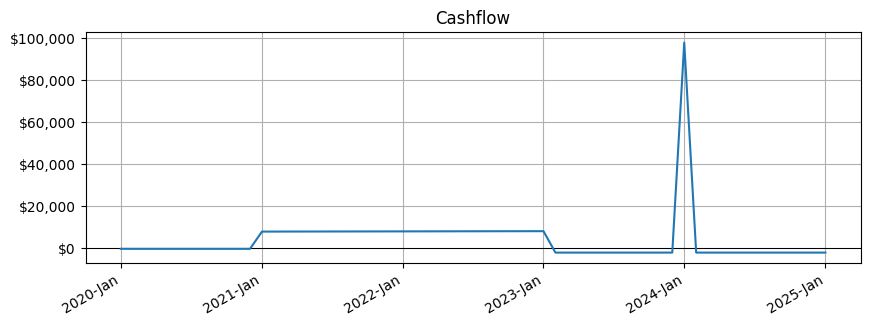

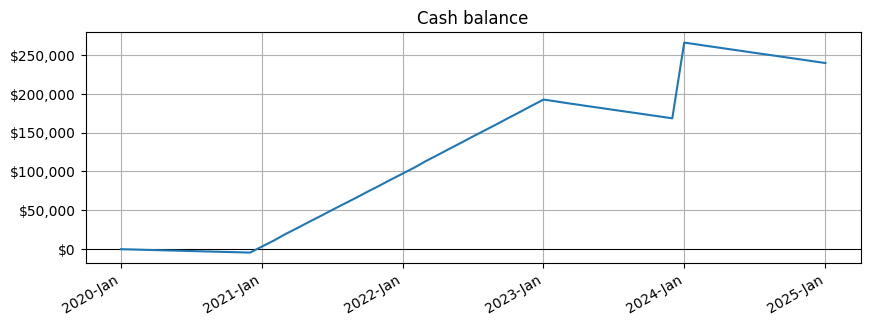

In [ ]:
# Create a graph.
output = fin.process(dates, incomes=incomes, expenses=expenses, liabilities=liabilities)
graph.plot('Cashflow', dates, output.cashflow)
graph.plot('Cash balance', dates, output.cash_balance)

## Assets

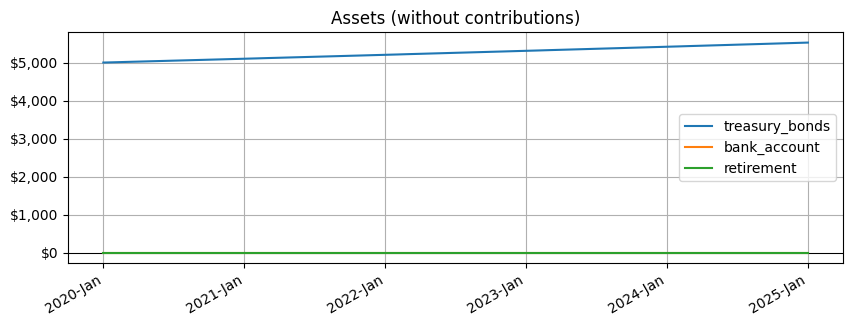

In [ ]:
assets = {
    "treasury_bonds": fin.Asset(5_000.0, start_date, rate=fin.AnnualFixedRate(0.02)),
    "bank_account": fin.Asset(0.0, start_date, rate=fin.AnnualFixedRate(0.0)),
    "retirement": fin.Asset(0.0, start_date, rate=fin.AnnualFixedRate(0.07)),
}

# Create a graph.
output = fin.process(dates, assets=assets)
graph.plot('Assets (without contributions)', dates, output.assets)


## Final assets and liabilities

If the cash balance is ever negative, then further funds are required to cover expenses in that period.

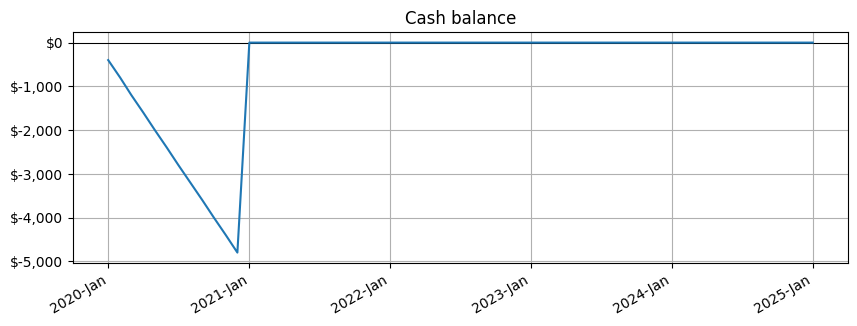

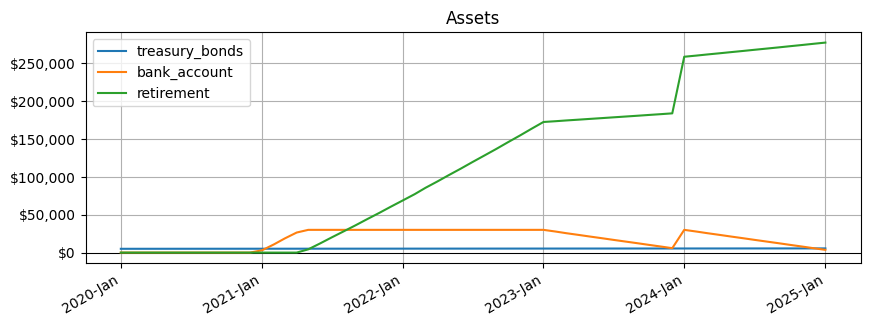

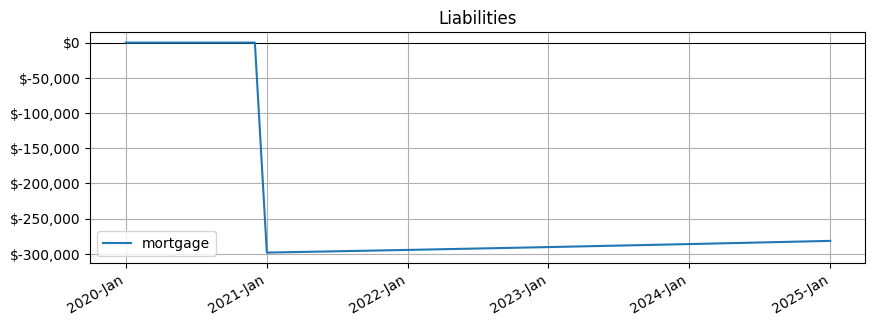

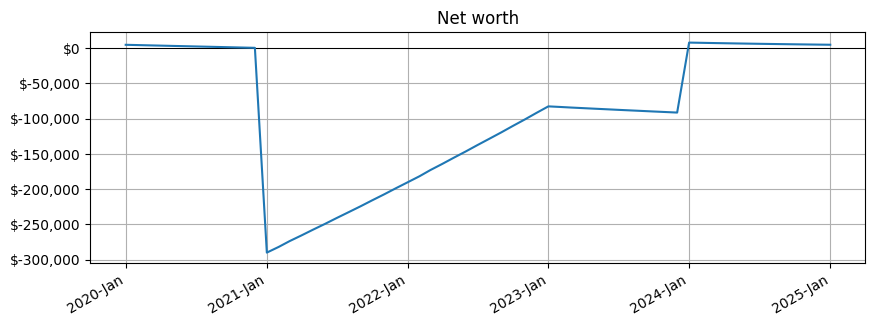

In [ ]:
# Specifies how cash flow should be contributed to assets/liabilities.
cash_handler = fin.SequentialCashHandler([
    # Adds money to bank account until its balance reaches X.
    fin.MaxValueCashHandler(assets['bank_account'], max_value=30_000.0), 
    # Add remaining cash to retirement.
    fin.BasicCashHandler(assets['retirement']),
])

# Create a graph.
output = fin.process(
    dates,
    incomes=incomes, 
    expenses=expenses, 
    liabilities=liabilities, 
    assets=assets, 
    cash_handler=cash_handler
)
graph.plot('Cash balance', dates, output.cash_balance)
graph.plot('Assets', dates, output.assets)
graph.plot('Liabilities', dates, output.liabilities)
graph.plot('Net worth', dates, output.net_worth)
